In [1]:
# Import Libraries

import os
import sys
import warnings                                 # `dnd` mode
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


import seaborn as sns
import matplotlib as plt
%matplotlib inline

In [2]:
blogtext_df = pd.read_csv("blogtext.csv")

In [3]:
#Check the shape of the data
blogtext_df.shape

(681284, 7)

1. It's a large dataset with lots of rows

2. It also seems like it is multilingual, which we will have to deal with as me move forward 

In [4]:
#Check the first 10 rows
blogtext_df.head(10)

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Somehow Coca-Cola has a way of su...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004","If anything, Korea is a country o..."
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Take a read of this news article ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",I surf the English news sites a l...


In [5]:
#check the feature/columns  
blogtext_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


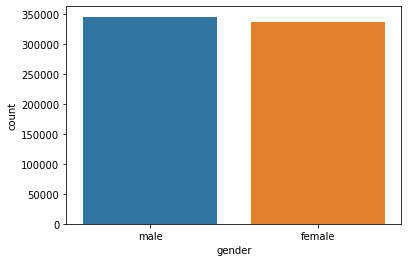

In [6]:
#Check gender-wise distribution
sns.countplot(x='gender',data=blogtext_df);

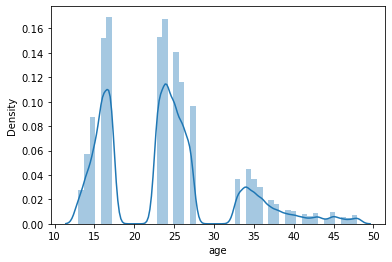

In [7]:
#Check age distribution
age = blogtext_df.age
sns.distplot(age);

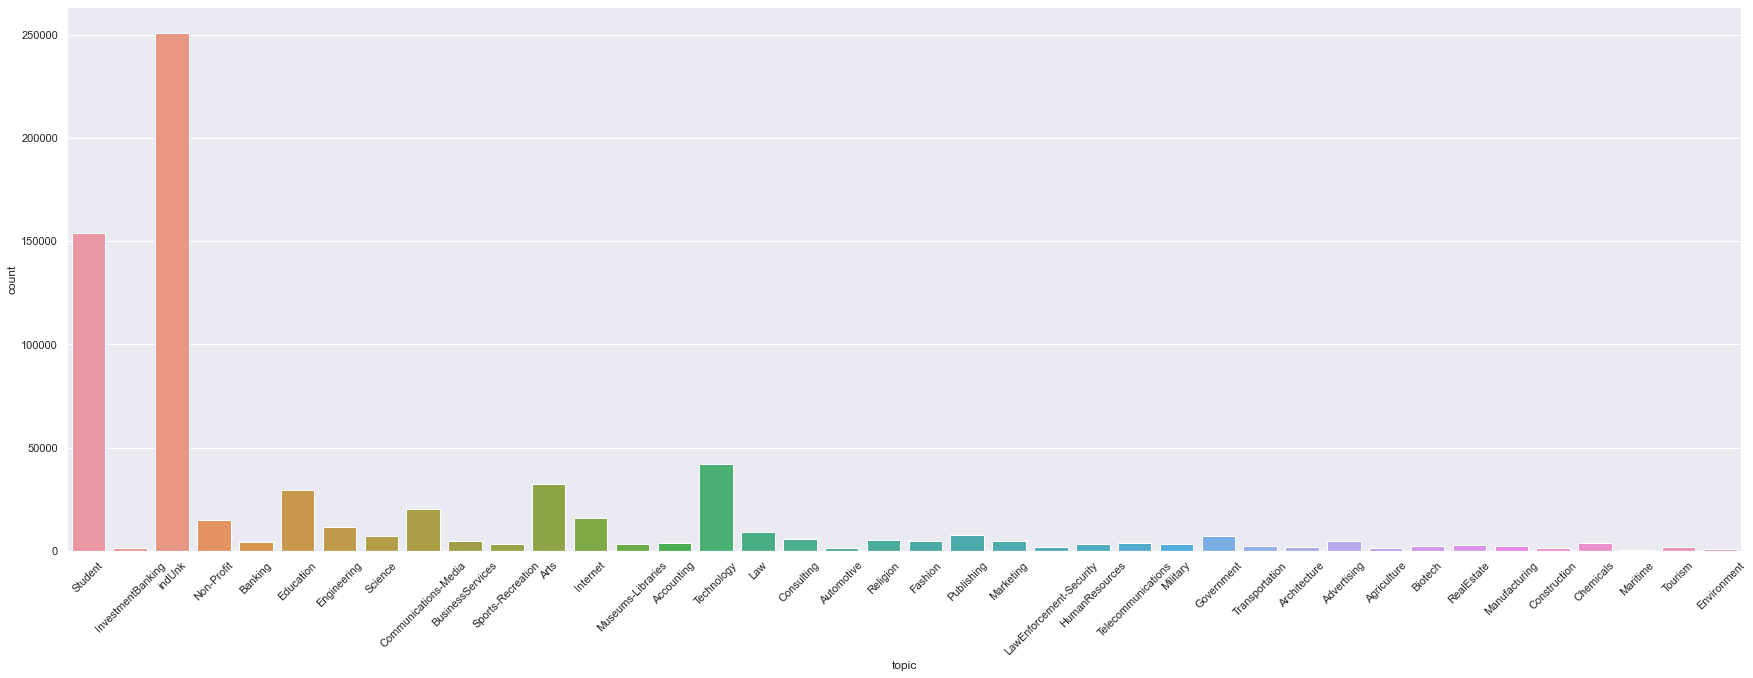

In [8]:
#Check the topic distribution
sns.set(rc={'figure.figsize':(30,10)})
ax = sns.countplot(x='topic',data=blogtext_df)
ax.xaxis.set_tick_params(rotation=45)

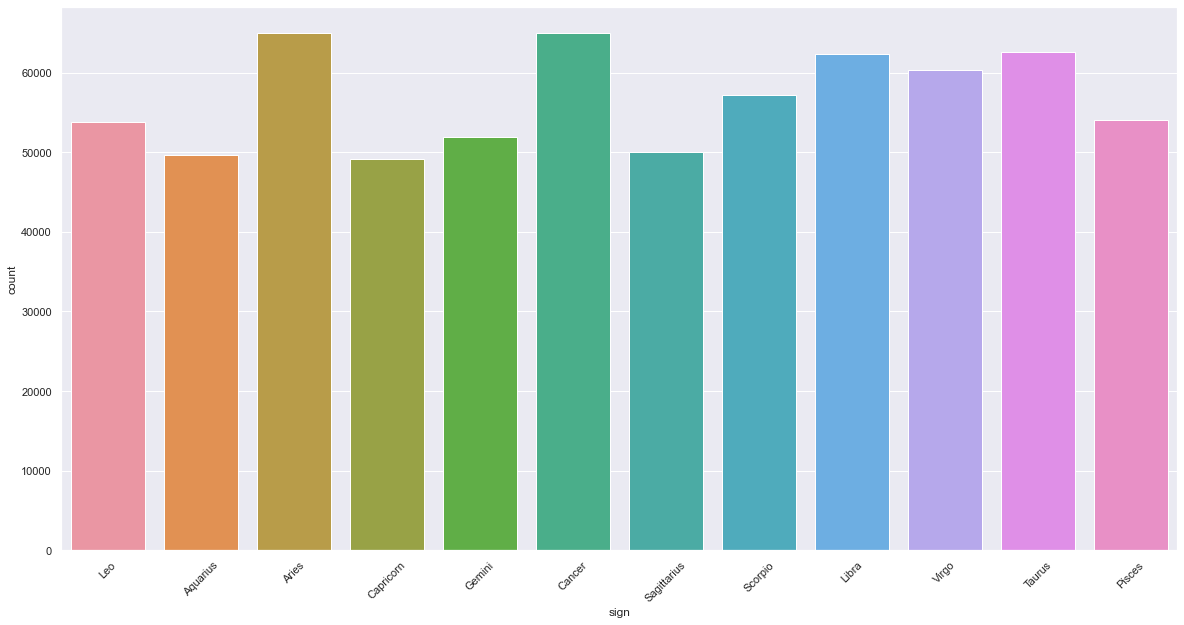

In [9]:
#Check the sign distribution
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.countplot(x='sign',data=blogtext_df)
ax.xaxis.set_tick_params(rotation = 45);

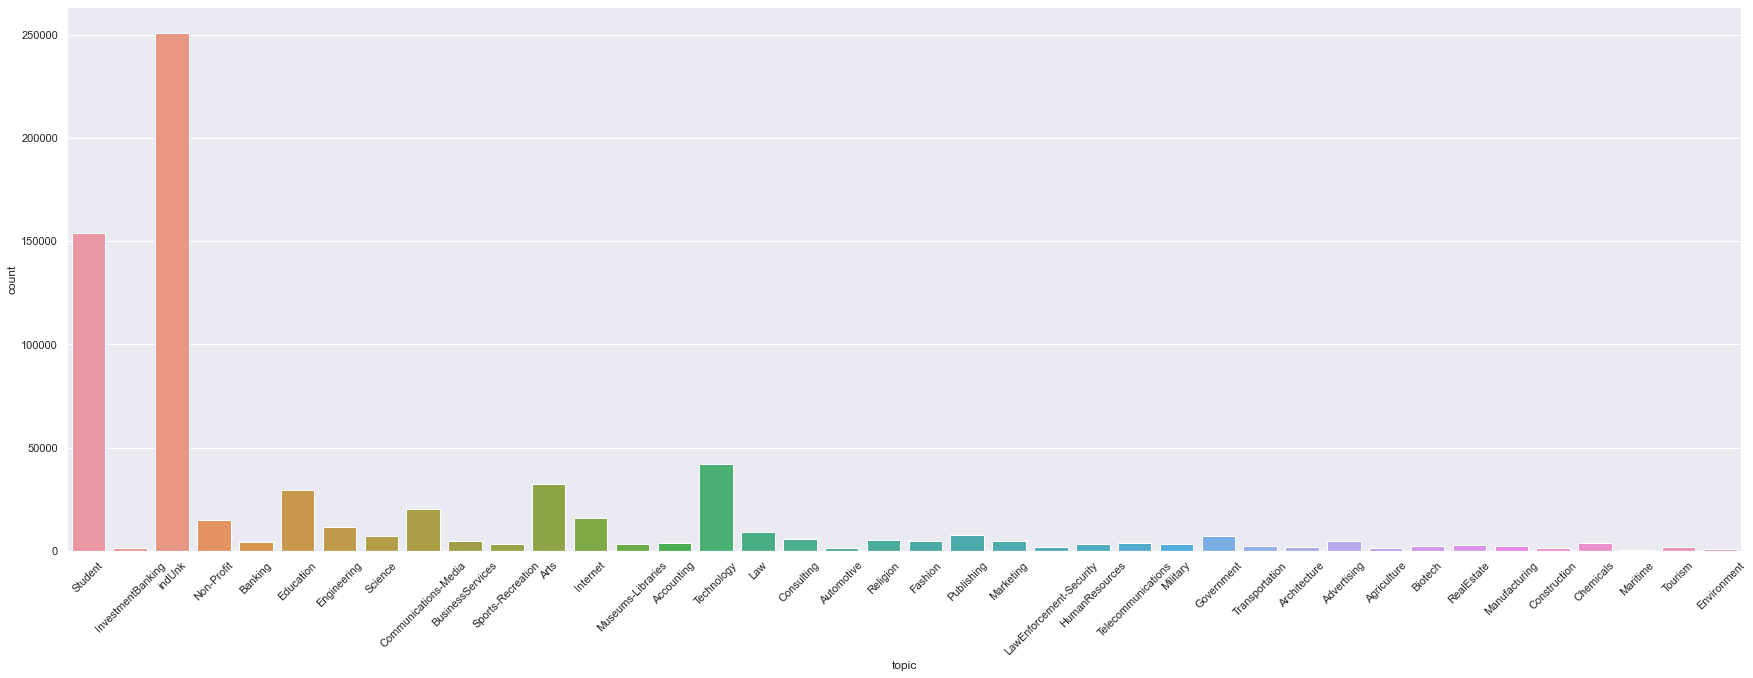

In [10]:
#Check the topic distribution
sns.set(rc={'figure.figsize':(30,10)})
ax = sns.countplot(x='topic',data=blogtext_df)
ax.xaxis.set_tick_params(rotation=45);

In [11]:
sample_df = pd.read_csv("blogtext.csv", nrows = 50000) #Taking 50000 samples for ease of computation

# Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase

In [12]:
# remove unwanted characters but keep the alphanum
pattern = "[^\w ]"
sample_df.text = sample_df.text.apply(lambda s : re.sub(pattern,"",s))

In [13]:
#convert all texts in text columns into lower case
sample_df.text = sample_df.text.apply(lambda s: s.lower())

In [14]:
#remove unwanted spaces
sample_df.text = sample_df.text.apply(lambda s: s.strip())

In [15]:
#remove stopwords
import nltk
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
sample_df.text = sample_df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bharat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#recheck data
sample_df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004",info found 100 pages 45 mb pdf files wait unti...
1,2059027,male,15,Student,Leo,"13,May,2004",team members drewes van der laag urllink mail ...
2,2059027,male,15,Student,Leo,"12,May,2004",het kader van kernfusie op aarde maak je eigen...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks yahoos toolbar capture urls popupswhich...


Exploratory Data Analysis on Sample



In [17]:
sample_df.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
id,50000.0,2.388443e+06,1.254200e+06,17944.0,1078077.0,2764903.0,3525620.0,4337133.0
age,50000.0,2.436214e+01,7.982836e+00,13.0,17.0,24.0,27.0,48.0


In [18]:
print(sample_df.age.value_counts())

17    6859
24    5746
23    5518
16    4156
27    4094
15    3508
35    3365
26    2869
25    2837
14    2043
36    1985
34    1886
33    1654
13     745
39     412
41     394
46     330
48     318
37     310
47     206
38     196
40     192
43     150
42      96
45      93
44      38
Name: age, dtype: int64


In [19]:
sample_df.describe(include = [np.object]).T

,count,unique,top,freq
gender,50000,2,male,25815
topic,50000,40,indUnk,17560
sign,50000,12,Aries,7795
date,50000,1180,"05,August,2004",2600
text,50000,49008,,203


In [20]:
## memory analysis

sample_df.memory_usage(deep=True)

Index          128
id          400000
gender     3098370
age         400000
topic      3246913
sign       3170411
date       3503955
text      37721996
dtype: int64

In [21]:
sample_df.gender.value_counts()

male      25815
female    24185
Name: gender, dtype: int64

<AxesSubplot:xlabel='age', ylabel='count'>

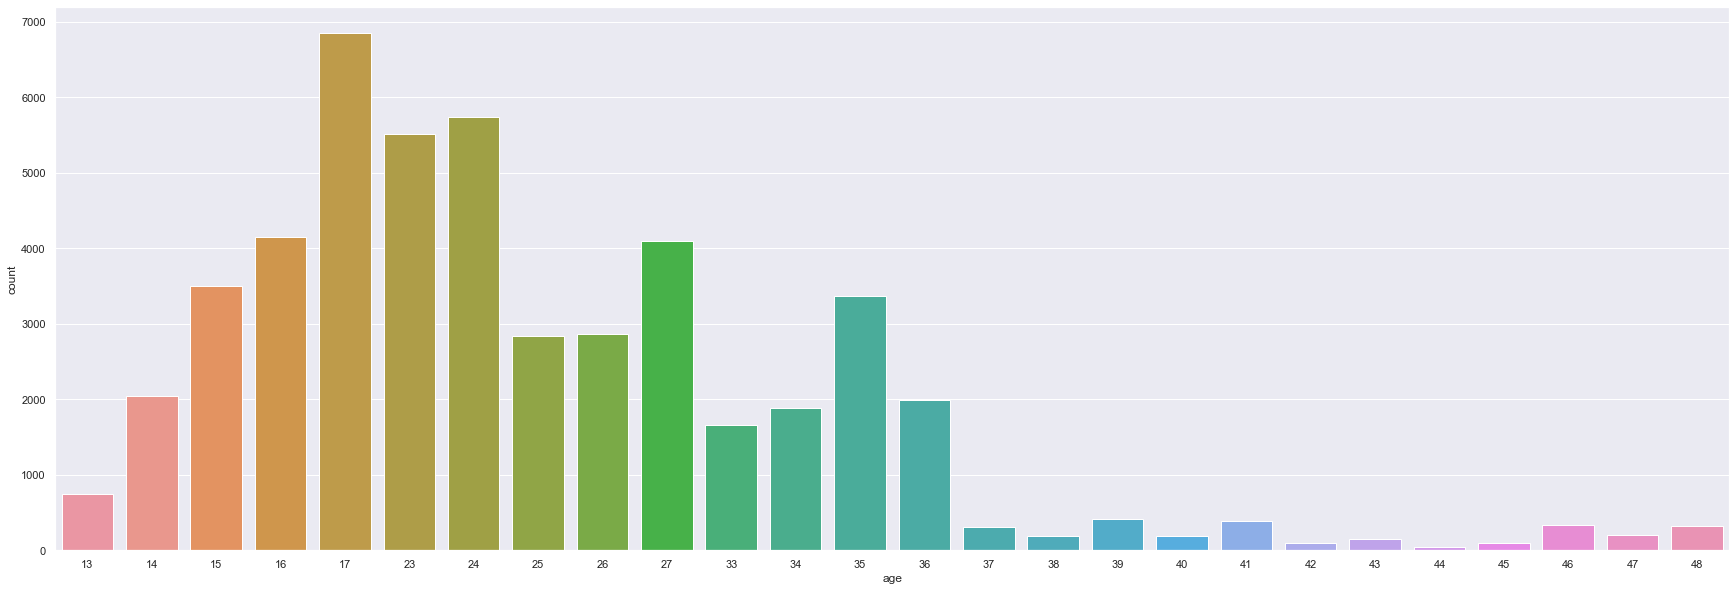

In [22]:
sns.countplot(x="age", data=sample_df)

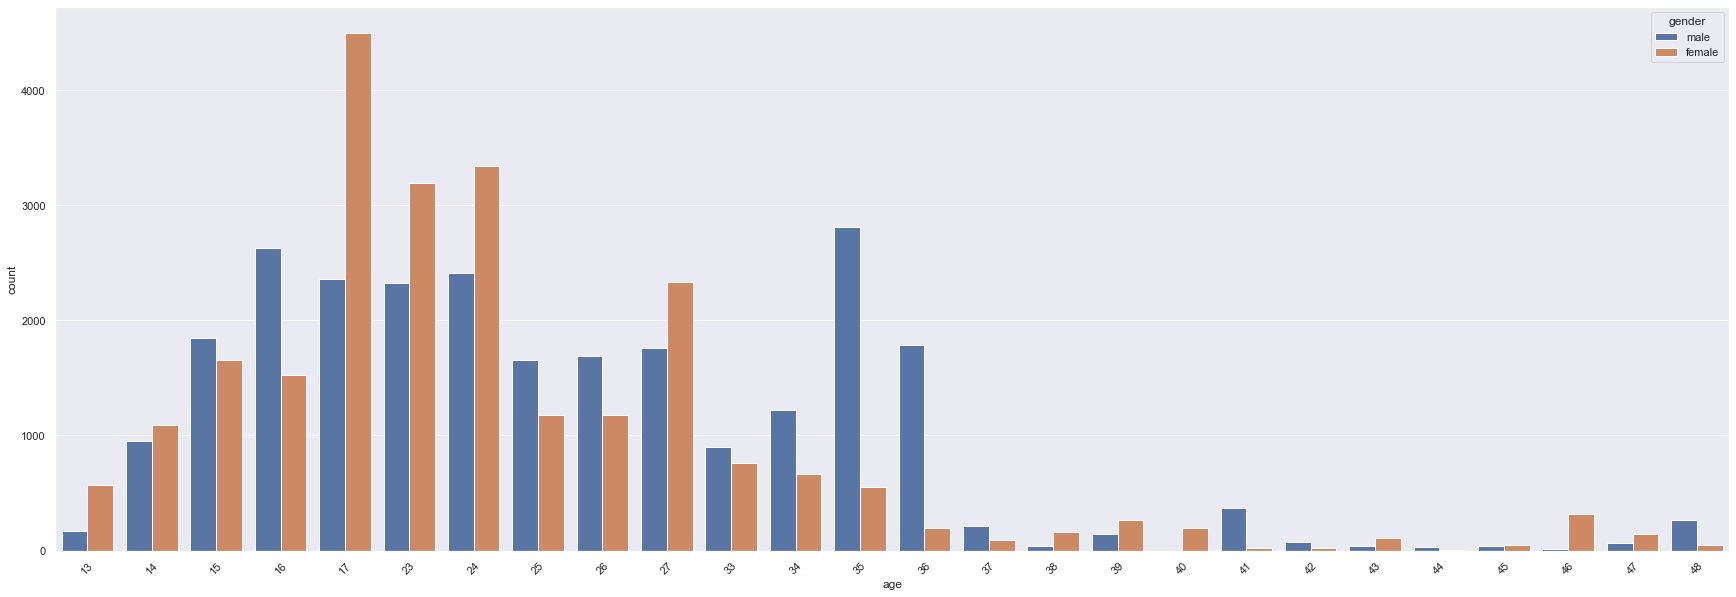

In [23]:
ax = sns.countplot(x="age", hue="gender", data=sample_df)
ax.xaxis.set_tick_params(rotation=45);

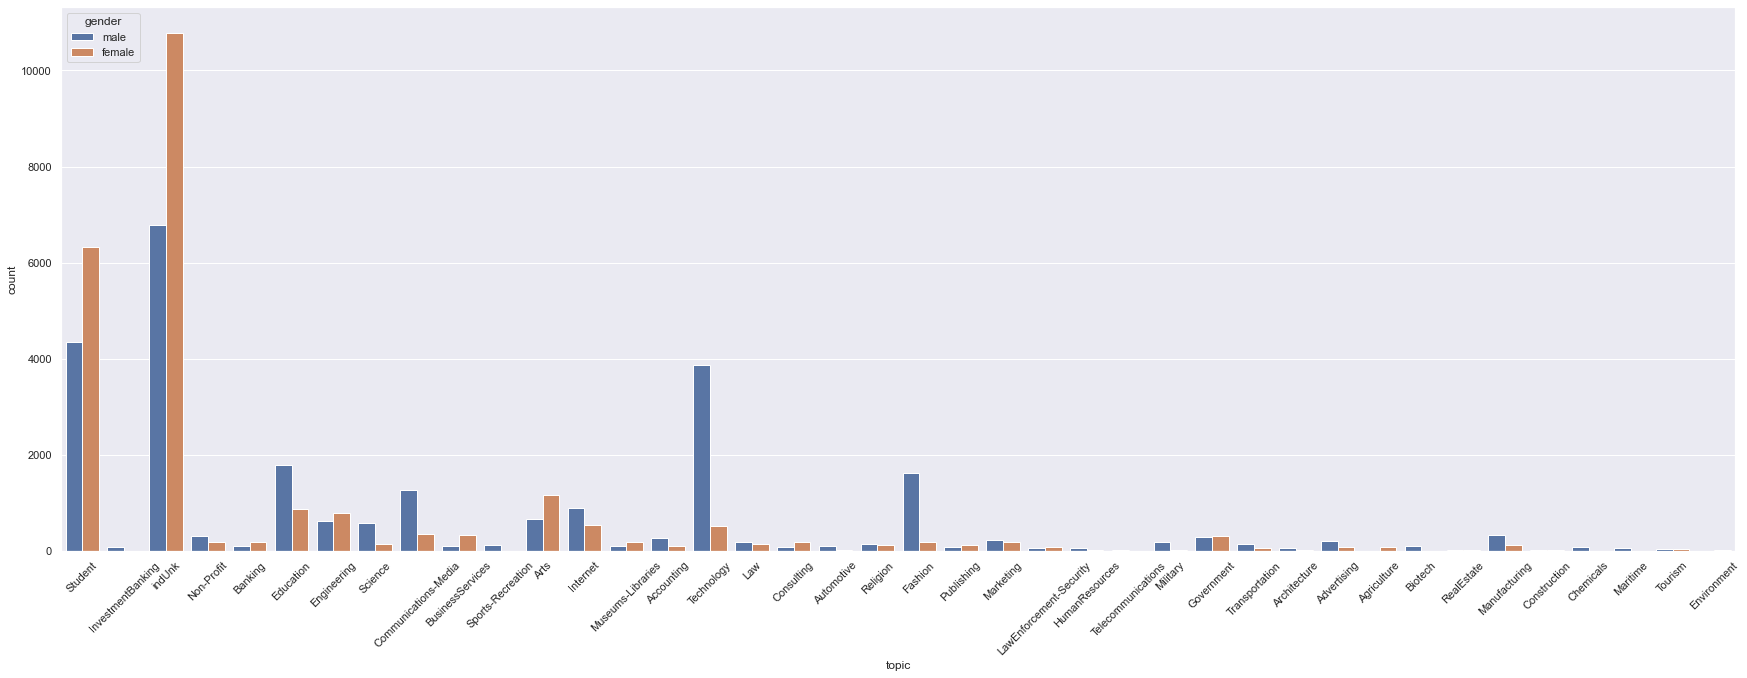

In [24]:
ax = sns.countplot(x="topic", hue="gender", data=sample_df)
ax.xaxis.set_tick_params(rotation=45);

Target/Label Merger and Transformation

In [25]:
sample_df['age'] = sample_df['age'].astype(str)
sample_df['labels'] = sample_df.apply(lambda col : [col['gender'],col['age'],col['topic'],col['sign']], axis=1)

In [26]:
#drop the columns which were merged to form the label column
sample_df.drop(columns=['gender','age','topic','sign', 'id', 'date'], axis=1, inplace=True)

In [27]:
sample_df.head()

,text,labels
0,info found 100 pages 45 mb pdf files wait unti...,"[male, 15, Student, Leo]"
1,team members drewes van der laag urllink mail ...,"[male, 15, Student, Leo]"
2,het kader van kernfusie op aarde maak je eigen...,"[male, 15, Student, Leo]"
3,testing testing,"[male, 15, Student, Leo]"
4,thanks yahoos toolbar capture urls popupswhich...,"[male, 33, InvestmentBanking, Aquarius]"


In [28]:
# Train and test split

X= sample_df.text
y = sample_df.labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

In [29]:
print("shape of training set :", X_train.shape)
print("shape of test set :", X_test.shape)

shape of training set : (40000,)
shape of test set : (10000,)


In [31]:
X_train[5]

'interesting conversation dad morning talking koreans put money invariably lot real estate cash cash would include short term investments one year well savings accounts reason real estate makes money lot money ive seen surveys seoul real estate rising 1015 per year long stretches even taking account 1997 crisis referred imf crisis although imf bailed korea compare korean corporate bonds fell 9099 1997 modestly recovered local stock market represented kospi version dow jones index gone appreciably 1980s high 1000 points 800 points see urllink link see real estate makes sense back conversationi noted real big elite real estate investor 6 billion usd 5000000 see urllink converter properties dad seemed little flabbergasted heck need 5 million dollars dont need much retire maybe lot risk take real estate south korean asset example north toots horn louder make move country 5000000 usd worth 5 cents also denominated imf crisis dropped 50 visavis usd also make bad investment fall victim scamth

In [32]:
y_train[5]

['male', '33', 'InvestmentBanking', 'Aquarius']

Vectorisation

Count Vectorizer on Bag of Words

In [33]:
ctv = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                      ngram_range=(1, 3), stop_words = 'english')
corpus = list(X_train)+list(X_test)

In [34]:
ctv.fit(corpus)

CountVectorizer(ngram_range=(1, 3), stop_words='english',
                token_pattern='\\w{1,}')

In [35]:
xtrain_ctv = ctv.transform(X_train)

In [36]:
xtest_ctv = ctv.transform(X_test)

In [37]:
print(len(ctv.vocabulary_))

7317901


In [38]:
ctv.get_feature_names()[:10]

['0',
 '0 0',
 '0 0 0',
 '0 0 1',
 '0 0 ___',
 '0 0 draw',
 '0 0 h',
 '0 0 italy',
 '0 0 switzerland',
 '0 0 theos']

TF-IDF (Term Frequency - Inverse Document Frequency)

In [39]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                      strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                      stop_words = 'english')


#Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_test))
xtrain_tfv =  tfv.transform(X_train) 
xvalid_tfv = tfv.transform(X_test)

Create a dictionary for the count of every label

In [40]:
label_counts=dict()

for labels in sample_df.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1
        
label_counts

{'male': 25815,
 '15': 3508,
 'Student': 10660,
 'Leo': 3904,
 '33': 1654,
 'InvestmentBanking': 85,
 'Aquarius': 4784,
 'female': 24185,
 '14': 2043,
 'indUnk': 17560,
 'Aries': 7795,
 '25': 2837,
 'Capricorn': 3819,
 '17': 6859,
 'Gemini': 2558,
 '23': 5518,
 'Non-Profit': 491,
 'Cancer': 4589,
 'Banking': 283,
 '37': 310,
 'Sagittarius': 4571,
 '26': 2869,
 '24': 5746,
 'Scorpio': 3243,
 '27': 4094,
 'Education': 2646,
 '45': 93,
 'Engineering': 1402,
 'Libra': 4378,
 'Science': 705,
 '34': 1886,
 '41': 394,
 'Communications-Media': 1603,
 'BusinessServices': 416,
 'Sports-Recreation': 120,
 'Virgo': 2827,
 'Taurus': 3390,
 'Arts': 1817,
 'Pisces': 4142,
 '44': 38,
 '16': 4156,
 'Internet': 1420,
 'Museums-Libraries': 285,
 'Accounting': 364,
 '39': 412,
 '35': 3365,
 'Technology': 4379,
 '36': 1985,
 'Law': 308,
 '46': 330,
 'Consulting': 243,
 'Automotive': 116,
 '42': 96,
 'Religion': 258,
 '13': 745,
 'Fashion': 1805,
 '38': 196,
 '43': 150,
 'Publishing': 207,
 '40': 192,
 'Mar

Use Multilabel Binarizer to Transform the Labels

In [41]:
# Transform between iterable of iterables and a multilabel format
# Transform labels in a binary form and the prediction will be a mask of 0s and 1s
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))


y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [42]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'),
                    n_jobs=-1)),])
LogReg_pipeline.fit(xtrain_ctv, y_train)

Y_predicted_oneVsRest = LogReg_pipeline.predict(xtest_ctv)

/Users/bharat/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bharat/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bharat/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bharat/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bharat/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bharat/opt/anaconda3/lib/python3.9/sit

In [44]:
# Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [45]:
def display_metrics_micro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Micro', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: Micro', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: Micro', recall_score(Ytest, Ypred, average='micro'))
    
    
def display_metrics_macro(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: Macro', f1_score(Ytest, Ypred, average='macro'))
    print('Average recall score: MAcro', recall_score(Ytest, Ypred, average='macro'))
    
def display_metrics_weighted(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: weighted', f1_score(Ytest, Ypred, average='weighted'))
    print('Average precision score: weighted', average_precision_score(Ytest, Ypred, average='weighted'))
    print('Average recall score: weighted', recall_score(Ytest, Ypred, average='weighted'))

In [46]:
display_metrics_micro(y_test,Y_predicted_oneVsRest)

Accuracy score:  0.0019
F1 score: Micro 0.24815420840483698
Average precision score: Micro 0.13779681975479535
Average recall score: Micro 0.15545


In [47]:
display_metrics_macro(y_test,Y_predicted_oneVsRest)

Accuracy score:  0.0019
F1 score: Macro 0.01769345722752458
Average recall score: MAcro 0.01669750348191694


In [48]:
display_metrics_weighted(y_test,Y_predicted_oneVsRest)

Accuracy score:  0.0019
F1 score: weighted 0.156096130291704
Average precision score: weighted 0.23362265896744516
Average recall score: weighted 0.15545


Check for any 5 inputs and there predicted labels

In [49]:
import random 

def print_predicted(y_predicted, y_test = y_test , n = 5):
    j = []
    for i in range(n):
        j.append(random.randint(0, len(y_test)))
    print(j)
                 
    for k in j:
        print(binarizer.inverse_transform(y_predicted)[k])
        print(binarizer.inverse_transform(y_test)[k])
        print("_____________________________________")

In [50]:
print_predicted(y_predicted=Y_predicted_oneVsRest,y_test=y_test, n= 10)

[1349, 5664, 9313, 4217, 5525, 6048, 6001, 9542, 9759, 1463]
('female',)
('24', 'Engineering', 'Libra', 'male')
_____________________________________
('female',)
('35', 'Virgo', 'female', 'indUnk')
_____________________________________
('male',)
('35', 'Aries', 'Technology', 'male')
_____________________________________
('male',)
('36', 'Aries', 'Fashion', 'male')
_____________________________________
('male',)
('24', 'Chemicals', 'Libra', 'male')
_____________________________________
('female',)
('26', 'Aquarius', 'indUnk', 'male')
_____________________________________
('male',)
('26', 'Advertising', 'Cancer', 'male')
_____________________________________
('female',)
('16', 'Student', 'Virgo', 'female')
_____________________________________
('female',)
('15', 'Aries', 'Student', 'female')
_____________________________________
('male',)
('23', 'Arts', 'Capricorn', 'female')
_____________________________________


Demonstration of input data preparation for neural network classifier

In [53]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [58]:
!pip install -U textblob
!python -m textblob.download_corpora

     |████████████████████████████████| 636 kB 1.9 MB/s eta 0:00:01
[nltk_data] Downloading package brown to /Users/bharat/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /Users/bharat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bharat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bharat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/bharat/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/bharat/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [59]:
# data manipulation
import pandas as pd

# library for NLP tasks, 
from textblob import TextBlob
import nltk
nltk.download('wordnet')
from textblob import Word 
# bag of words and tf-idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package wordnet to /Users/bharat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [61]:
df = pd.read_csv("blogtext.csv")

In [62]:
df.topic = df.topic.astype(str)

In [63]:
# datasize is huge. Keeping only few topics which are our target classe 
# after that perform downsampling to balance the classes
df_student = df[ (df.topic == 'Student') ] 
df_tech =   df[ (df.topic == 'Technology') ]
df_arts     = df[(df.topic == 'Arts')]       
df_non_profit = df[(df.topic == 'Non-Profit')]
df_law = df[df.topic == 'Law']
df_gov = df[(df.topic == 'Government')]
df_rel = df[(df.topic == 'Religion')]
df_fashion = df[(df.topic == 'Fashion')]

In [64]:
# use resample method from scikit-learn
from sklearn.utils import resample

df_student = resample(df_student, 
                      replace=True,    # sample with replacement
                      n_samples=5000,     # to match number of values in each class
                      random_state=123) # reproducible results

df_tech = resample(df_tech, 
                      replace=True,    # sample with replacement
                      n_samples=5000,     # to match number of values in each class
                      random_state=123) # reproducible results

df_arts = resample(df_arts, 
                      replace=True,    # sample with replacement
                      n_samples=5000,     # to match number of values in each class
                      random_state=123) # reproducible results

df_non_profit = resample(df_non_profit, 
                      replace=True,    # sample with replacement
                      n_samples=5000,     # to match number of values in each class
                      random_state=123) # reproducible results

df_law = resample(df_law, 
                      replace=True,    # sample with replacement
                      n_samples=5000,     # to match number of values in each class
                      random_state=123) # reproducible results

df_gov = resample(df_gov, 
                      replace=True,    # sample with replacement
                      n_samples=5000,     # to match number of values in each class
                      random_state=123) # reproducible results

df_rel = resample(df_rel, 
                      replace=True,    # sample with replacement
                      n_samples=5000,     # to match number of values in each class
                      random_state=123) # reproducible results

In [65]:
# Combine all the class with equal number of values
df = pd.concat([df_student, df_tech, df_arts, df_non_profit, df_law, df_gov, df_rel, df_fashion ])

# check for the class balance
df['topic'].value_counts()

Student       5000
Technology    5000
Arts          5000
Non-Profit    5000
Law           5000
Government    5000
Religion      5000
Fashion       4851
Name: topic, dtype: int64

In [66]:
df.head()

,id,gender,age,topic,sign,date,text
72398,479019,male,24,Student,Gemini,"02,July,2004",Ive been watching a lot of movies...
132682,3622174,male,16,Student,Leo,"25,June,2004","Zuma, by Pop Cap games, is one o..."
82810,1478632,male,17,Student,Leo,"30,May,2003","[Step Up Day? WTF?] Yeah, the eighth ..."
543401,2973911,male,17,Student,Sagittarius,"01,September,2003","Ok, so i haven't posted for some ti..."
650855,891544,male,27,Student,Libra,"28,July,2004",hi gang... the hunt may have to be pos...


In [67]:
df['age'] = df['age'].astype(str)

In [68]:
df['label'] = df[['gender', 'age', 'topic', 'sign']].apply(lambda x: ' '.join(x), axis = 1)

print(df)

             id  gender age    topic         sign               date  \
72398    479019    male  24  Student       Gemini       02,July,2004   
132682  3622174    male  16  Student          Leo       25,June,2004   
82810   1478632    male  17  Student          Leo        30,May,2003   
543401  2973911    male  17  Student  Sagittarius  01,September,2003   
650855   891544    male  27  Student        Libra       28,July,2004   
...         ...     ...  ..      ...          ...                ...   
680242  1722161  female  23  Fashion        Libra       15,July,2004   
680243  1722161  female  23  Fashion        Libra       12,July,2004   
680244  1722161  female  23  Fashion        Libra       11,July,2004   
680245  1722161  female  23  Fashion        Libra       09,July,2004   
680246  1722161  female  23  Fashion        Libra     07,August,2004   

                                                     text  \
72398                Ive been watching a lot of movies...   
132682       

In [69]:
text = df[['text', 'label']]

In [70]:
print(text[text.groupby("label")["label"].transform('size') == 50])

                                                     text  \
659799                     Cognize Maddie     Random F...   
82664          todAy g0t nPcC ph0to-taking sessIon.. a...   
597447                    Oh well as my earlier entry ...   
312545             Laying in bed, trying to figure out...   
490294          CURRENT ....     [ current clothes]  r...   
...                                                   ...   
563438     We didn't get a chance to get to Minneapoli...   
563455     When I was at Michael's I decided to pick u...   
563446     Ronald Reagan's funeral was today. Nearly e...   
563471     Went to the Rice Street Festival yesterday....   
563455     When I was at Michael's I decided to pick u...   

                                 label  
659799        female 16 Student Taurus  
82664         female 16 Student Taurus  
597447        female 16 Student Taurus  
312545        female 16 Student Taurus  
490294        female 16 Student Taurus  
...                  

In [71]:
data = text[text.groupby("label")["label"].transform('size') == 20]

In [72]:
data['text'] = data['text'].apply( lambda t : ' '.join( word.lower() for word in t.split()  ) )
data['text'].head(5)

422637    urllink god can turn high money-spinning fashi...
232041    bludgy days ...this week. today we only had on...
91583     lovin' the picture chichi and you should've sl...
91544     hey everybody i went to the concert and it was...
292924    msh vs gms full time report-- padang field a.....
Name: text, dtype: object

In [73]:
# 2. Remove punctuations
# the [^\w\s] means remove everything, keep only words(w) and spaces(s)
# this step should be done after feature extraction like hashtags, user tagged
data['text'] = data['text'].str.replace( '[^\w\s]' , '' )
data['text'].head(10)

422637    urllink god can turn high moneyspinning fashio...
232041    bludgy days this week today we only had one pr...
91583     lovin the picture chichi and you shouldve slap...
91544     hey everybody i went to the concert and it was...
292924    msh vs gms full time report padang field athe ...
539776    hmm well whats been happing with me lately las...
539773    so i saw urllink the bourne supremacy a few we...
660101    well he worked and got drunk what a way to spe...
421381    ive always wondered why people take part in th...
577844    what do that both person mean to you mr sandma...
Name: text, dtype: object

In [74]:
# 3 . Remove stop words - the, a , and etc. These are most commonly occuring words, and may created irrevelent 
# baises to our model
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply( lambda t : " ".join( word for word in t.split() 
                                                       if word not in stop ) )

In [75]:
# 4. Frequent word removal from the text; text which are not stopwords
# first we will take whole tweets data and split into words and then calculate their frequency
#  join words only with strings so, there needs to be some string to join other string
all_words = ' '.join( data['text'] ).split()
freqeuncy = pd.Series(all_words).value_counts()[:20]

In [76]:
freqeuncy

urllink    328
like       315
im         290
n          233
get        207
really     203
one        202
dont       194
know       180
think      164
see        157
time       156
well       154
would      153
good       151
much       140
people     137
go         135
movie      133
got        125
dtype: int64

In [77]:
# remove frequenct words
data['text'] = data['text'].apply( lambda t : ' '.join( word for word in t.split() 
                                                      if word not in freqeuncy) )
data['text'].head(10)

422637    god turn high moneyspinning fashion advantage ...
232041    bludgy days week today proper period work math...
91583     lovin picture chichi shouldve slapped dude kep...
91544     hey everybody went concert kinda fun guess lik...
292924    msh vs gms full report padang field athe game ...
539776    hmm whats happing lately last weekend went cam...
539773    saw bourne supremacy weeks ago must admit grea...
660101    worked drunk way spend bday cused charge phone...
421381    ive always wondered take part lotteryits obvio...
577844    person mean mr sandman mr dreammaker sometimes...
Name: text, dtype: object

In [78]:
# 6. Remove whitespaces
data['text'] = data['text'].str.strip()
data['text'].head(10)

422637    god turn high moneyspinning fashion advantage ...
232041    bludgy days week today proper period work math...
91583     lovin picture chichi shouldve slapped dude kep...
91544     hey everybody went concert kinda fun guess lik...
292924    msh vs gms full report padang field athe game ...
539776    hmm whats happing lately last weekend went cam...
539773    saw bourne supremacy weeks ago must admit grea...
660101    worked drunk way spend bday cused charge phone...
421381    ive always wondered take part lotteryits obvio...
577844    person mean mr sandman mr dreammaker sometimes...
Name: text, dtype: object

In [79]:
# Remove Numberic
import re

def remove_num(t):
    removed_num_text = re.sub(r'\d+', '', t)
    return removed_num_text

data['text'] = data['text'].apply( lambda t : remove_num(t) )
data['text'].head(10)

422637    god turn high moneyspinning fashion advantage ...
232041    bludgy days week today proper period work math...
91583     lovin picture chichi shouldve slapped dude kep...
91544     hey everybody went concert kinda fun guess lik...
292924    msh vs gms full report padang field athe game ...
539776    hmm whats happing lately last weekend went cam...
539773    saw bourne supremacy weeks ago must admit grea...
660101    worked drunk way spend bday cused charge phone...
421381    ive always wondered take part lotteryits obvio...
577844    person mean mr sandman mr dreammaker sometimes...
Name: text, dtype: object

In [80]:
# 8 . Lemmatization ; its preferred over stemming because if finds the root word
# perform lemmatization on the title
data['text'] = data['text'].apply( lambda t : " ".join( [Word(word).lemmatize() for word in t.split()  ]) )
data['text'].head(5)

422637    god turn high moneyspinning fashion advantage ...
232041    bludgy day week today proper period work math ...
91583     lovin picture chichi shouldve slapped dude kep...
91544     hey everybody went concert kinda fun guess lik...
292924    msh v gm full report padang field athe game st...
Name: text, dtype: object

In [81]:
# 9. Bag of words
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data.text.values.astype('str'))

data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data.index

In [82]:
data_dtm.head()

,__,___,____,_________,aa,aaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhh,aaaahhhhh,aaah,aaarrggghhh,aag,...,zombie,zombrano,zooming,zrk,zulund,último,útil,мои,носки,трясет
422637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232041,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
data.label

422637        male 23 Student Aries
232041    male 14 Student Capricorn
91583     male 14 Student Capricorn
91544     male 14 Student Capricorn
292924    male 14 Student Capricorn
                    ...            
318062      female 15 Fashion Aries
318063      female 15 Fashion Aries
318064      female 15 Fashion Aries
318065      female 15 Fashion Aries
318066      female 15 Fashion Aries
Name: label, Length: 340, dtype: object

In [84]:
data[['gender','age', 'topic', 'sign']] = data.label.str.split(expand=True)

In [85]:
data.head()

,text,label,gender,age,topic,sign
422637,god turn high moneyspinning fashion advantage ...,male 23 Student Aries,male,23,Student,Aries
232041,bludgy day week today proper period work math ...,male 14 Student Capricorn,male,14,Student,Capricorn
91583,lovin picture chichi shouldve slapped dude kep...,male 14 Student Capricorn,male,14,Student,Capricorn
91544,hey everybody went concert kinda fun guess lik...,male 14 Student Capricorn,male,14,Student,Capricorn
292924,msh v gm full report padang field athe game st...,male 14 Student Capricorn,male,14,Student,Capricorn


In [86]:
data = data.drop('label', axis = 1)

In [87]:
data['age'] = data['age'].astype(str)
data['labels'] = data.apply(lambda col : [col['gender'],col['age'],col['topic'],col['sign']], axis=1)

In [88]:
data.head()

,text,gender,age,topic,sign,labels
422637,god turn high moneyspinning fashion advantage ...,male,23,Student,Aries,"[male, 23, Student, Aries]"
232041,bludgy day week today proper period work math ...,male,14,Student,Capricorn,"[male, 14, Student, Capricorn]"
91583,lovin picture chichi shouldve slapped dude kep...,male,14,Student,Capricorn,"[male, 14, Student, Capricorn]"
91544,hey everybody went concert kinda fun guess lik...,male,14,Student,Capricorn,"[male, 14, Student, Capricorn]"
292924,msh v gm full report padang field athe game st...,male,14,Student,Capricorn,"[male, 14, Student, Capricorn]"


In [89]:
X= data_dtm.values
y = data.labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

In [90]:
label_counts=dict()

for labels in data.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[str(label)]+=1
        else:
            label_counts[str(label)]=1
        
label_counts

{'male': 200,
 '23': 40,
 'Student': 80,
 'Aries': 60,
 '14': 40,
 'Capricorn': 40,
 'Sagittarius': 60,
 'female': 140,
 'Scorpio': 20,
 '26': 40,
 'Technology': 40,
 '27': 40,
 'Aquarius': 20,
 '16': 20,
 'Arts': 120,
 'Libra': 20,
 'Gemini': 40,
 '34': 20,
 'Leo': 20,
 '33': 20,
 'Pisces': 60,
 '17': 20,
 '37': 20,
 '36': 20,
 'Non-Profit': 20,
 'Law': 20,
 '45': 20,
 'Religion': 40,
 '15': 40,
 'Fashion': 20}

In [91]:
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))


y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [92]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

clf_model = Sequential()
clf_model.add(Dense(128, input_shape=(len(X_train[0]),), activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(64, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(len(y_train[0]), activation='softmax'))
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
clf_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#fitting and saving the model 
clf_hist = clf_model.fit(np.array(X_train), np.array(y_train), epochs=10, batch_size=5, verbose=1)

2023-01-13 18:38:19.951797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
55/55 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.0368                            
Epoch 2/10
55/55 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1140
Epoch 3/10
55/55 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.1140
Epoch 4/10
55/55 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1140
Epoch 5/10
55/55 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.1140
Epoch 6/10
55/55 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.1140
Epoch 7/10
55/55 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.1140
Epoch 8/10
55/55 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1140
Epoch 9/10
55/55 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.1140
Epoch 10/10
55/55 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.1140


The logistic regression model on top has a poor predictive accuracy. We can also check with svm and nbayes the accuracy. There is a tradeoff between time to train model and model accuracy. I have not tuned the neural net for the paucity of time. However, it would be much faster. This could be due to exploding gradient problem, which can be solved with tuning the activation function, lr. I have not tried that here since the aim of the project was to demonstrate converting blogtext data in a usable form for both ml and nn models. The same has been successfully achieved in the above sections.

Chat Bot Developemt 

In [93]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random

[nltk_data] Downloading package wordnet to /Users/bharat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bharat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [94]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('GL Bot.json').read()
intents = json.loads(data_file)

In [95]:
intents

{'intents': [{'tag': 'Intro',
   'patterns': ['hi',
    'how are you',
    'is anyone there',
    'hello',
    'whats up',
    'hey',
    'yo',
    'listen',
    'please help me',
    'i am learner from',
    'i belong to',
    'aiml batch',
    'aifl batch',
    'i am from',
    'my pm is',
    'blended',
    'online',
    'i am from',
    'hey ya',
    'talking to you for first time'],
   'responses': ['Hello! how can i help you ?'],
   'context_set': ''},
  {'tag': 'Exit',
   'patterns': ['thank you',
    'thanks',
    'cya',
    'see you',
    'later',
    'see you later',
    'goodbye',
    'i am leaving',
    'have a Good day',
    'you helped me',
    'thanks a lot',
    'thanks a ton',
    'you are the best',
    'great help',
    'too good',
    'you are a good learning buddy'],
   'responses': ['I hope I was able to assist you, Good Bye'],
   'context_set': ''},
  {'tag': 'Olympus',
   'patterns': ['olympus',
    'explain me how olympus works',
    'I am not able to understan

In [96]:
intents['intents'][0]

{'tag': 'Intro',
 'patterns': ['hi',
  'how are you',
  'is anyone there',
  'hello',
  'whats up',
  'hey',
  'yo',
  'listen',
  'please help me',
  'i am learner from',
  'i belong to',
  'aiml batch',
  'aifl batch',
  'i am from',
  'my pm is',
  'blended',
  'online',
  'i am from',
  'hey ya',
  'talking to you for first time'],
 'responses': ['Hello! how can i help you ?'],
 'context_set': ''}

In [97]:
len(intents['intents'])

8

In [98]:
intents['intents'][4] #printing the core support dictionary

{'tag': 'NN',
 'patterns': ['what is deep learning',
  'unable to understand deep learning',
  'explain me how deep learning works',
  'i am not able to understand deep learning',
  'not able to understand neural nets',
  'very diffult to understand neural nets',
  'unable to understand neural nets',
  'ann',
  'artificial intelligence',
  'artificial neural networks',
  'weights',
  'activation function',
  'hidden layers',
  'softmax',
  'sigmoid',
  'relu',
  'otimizer',
  'forward propagation',
  'backward propagation',
  'epochs',
  'epoch',
  'what is an epoch',
  'adam',
  'sgd'],
 'responses': ['Link: Neural Nets wiki'],
 'context_set': ''}

In [99]:
intents['intents'][4]['patterns'].append('nlp is very difficult')

In [100]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))
        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [101]:
# lemmatize, lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

129 documents
8 classes ['Bot', 'Exit', 'Intro', 'NN', 'Olympus', 'Profane', 'SL', 'Ticket']
160 unique lemmatized words ['a', 'able', 'access', 'activation', 'ada', 'adam', 'aifl', 'aiml', 'am', 'an', 'ann', 'anyone', 'are', 'artificial', 'backward', 'bad', 'bagging', 'batch', 'bayes', 'belong', 'best', 'blended', 'bloody', 'boosting', 'bot', 'buddy', 'classification', 'contact', 'create', 'cross', 'cya', 'day', 'deep', 'did', 'difficult', 'diffult', 'do', 'ensemble', 'epoch', 'explain', 'first', 'for', 'forest', 'forward', 'from', 'function', 'good', 'goodbye', 'gradient', 'great', 'hate', 'have', 'hell', 'hello', 'help', 'helped', 'hey', 'hi', 'hidden', 'hour', 'how', 'hyper', 'i', 'imputer', 'in', 'intelligence', 'is', 'jerk', 'joke', 'knn', 'later', 'layer', 'learner', 'learning', 'leaving', 'link', 'listen', 'logistic', 'lot', 'machine', 'me', 'ml', 'my', 'naive', 'name', 'nb', 'net', 'network', 'neural', 'nlp', 'no', 'not', 'of', 'olympus', 'olypus', 'on', 'online', 'operation',

In [102]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


In [103]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#fitting and saving the model 
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)
print("model created")

Epoch 1/200
26/26 [==============================] - 1s 3ms/step - loss: 2.0653 - accuracy: 0.1628
Epoch 2/200
26/26 [==============================] - 0s 4ms/step - loss: 1.9485 - accuracy: 0.2481
Epoch 3/200
26/26 [==============================] - 0s 3ms/step - loss: 1.8835 - accuracy: 0.2403
Epoch 4/200
26/26 [==============================] - 0s 3ms/step - loss: 1.7624 - accuracy: 0.3178
Epoch 5/200
26/26 [==============================] - 0s 3ms/step - loss: 1.7291 - accuracy: 0.3643
Epoch 6/200
26/26 [==============================] - 0s 3ms/step - loss: 1.6198 - accuracy: 0.4186
Epoch 7/200
26/26 [==============================] - 0s 3ms/step - loss: 1.4964 - accuracy: 0.5039
Epoch 8/200
26/26 [==============================] - 0s 4ms/step - loss: 1.3943 - accuracy: 0.5271
Epoch 9/200
26/26 [==============================] - 0s 3ms/step - loss: 1.2267 - accuracy: 0.5581
Epoch 10/200
26/26 [==============================] - 0s 3ms/step - loss: 1.1632 - accuracy: 0.6434
Epoch 11/

In [104]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

In [106]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np
import json
import random
from keras.models import load_model
model = load_model('chatbot_model.h5')
intents = json.loads(open('GL Bot.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))

In [107]:
def clean_up_sentence(sentence):
    # tokenize the pattern - split words into array
    sentence_words = nltk.word_tokenize(sentence)
    # stem each word - create short form for word
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words
# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words) 
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))
def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

In [108]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result
def chatbot_response(text):
    ints = predict_class(text, model)
    res = getResponse(ints, intents)
    return res

In [109]:
chatbot_response("where is nlp")

1/1 [==============================] - 0s 244ms/step


'Link: Neural Nets wiki'

In [ ]:
#text chat utility function

def chat():
  print("Chat with Bharat (type: stop to quit)")
  print("if answer is not right (type: *)")
  while True:
    inp = input("\n\nYou:")
    if inp.lower() == "*":
      print("BOT: Please rephrase your question and try again")
    if inp.lower() == "quit":
      break

    results = chatbot_response(inp)
    print(results)

In [ ]:
chat()